In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [2]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5048/868335/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1679157285&Signature=6Wt3w5s2%2FAURUG2cytKNekGsjTTpUx80hcMuxz1w%2FKwnOorTjWN2q7WReE7tRuHcvHSvwVMlFsAkMpKl1T2ZaVW3BV63RY9lRgpmHT31509x19zAFgcbX9MYUUYRJZN5ODfE%2BKTorLLeT7bZYrxa66AojtQPoa0L%2BWAGl36FGRCQ1j%2FBMRNjHvyDTqybm%2BGEzlfESZCxTG7DYhVURNFkBxsXV7M7pvAh8cbOIp5fBOqRyal8tkLWxXFGTqicDDIxbxVFXCPY8rSrBV%2FDZQ6ZnX6AvMEdy1bvR4395RtIPYu%2FJjarAnjRJXfG5uvX1Z84ZV2iKHMo2Y%2BfCU34CkakFA%3D%3D&response-content-disposition=attachment%3B+filename%3Dstate-farm-distracted-driver-detection.zip" -c -O 'state-farm-distracted-driver-detection.zip'

--2023-03-16 04:34:13--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5048/868335/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1679157285&Signature=6Wt3w5s2%2FAURUG2cytKNekGsjTTpUx80hcMuxz1w%2FKwnOorTjWN2q7WReE7tRuHcvHSvwVMlFsAkMpKl1T2ZaVW3BV63RY9lRgpmHT31509x19zAFgcbX9MYUUYRJZN5ODfE%2BKTorLLeT7bZYrxa66AojtQPoa0L%2BWAGl36FGRCQ1j%2FBMRNjHvyDTqybm%2BGEzlfESZCxTG7DYhVURNFkBxsXV7M7pvAh8cbOIp5fBOqRyal8tkLWxXFGTqicDDIxbxVFXCPY8rSrBV%2FDZQ6ZnX6AvMEdy1bvR4395RtIPYu%2FJjarAnjRJXfG5uvX1Z84ZV2iKHMo2Y%2BfCU34CkakFA%3D%3D&response-content-disposition=attachment%3B+filename%3Dstate-farm-distracted-driver-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4296022692 (4.0G) [application/zip]
Saving to: ‘state-f

In [ ]:
!unzip 'state-farm-distracted-driver-detection.zip'

Archive:  state-farm-distracted-driver-detection.zip
  inflating: driver_imgs_list.csv    
  inflating: imgs/test/img_1.jpg     
  inflating: imgs/test/img_10.jpg    
  inflating: imgs/test/img_100.jpg   
  inflating: imgs/test/img_1000.jpg  
  inflating: imgs/test/img_100000.jpg  
  inflating: imgs/test/img_100001.jpg  
  inflating: imgs/test/img_100002.jpg  
  inflating: imgs/test/img_100003.jpg  
  inflating: imgs/test/img_100004.jpg  
  inflating: imgs/test/img_100005.jpg  
  inflating: imgs/test/img_100007.jpg  
  inflating: imgs/test/img_100008.jpg  
  inflating: imgs/test/img_100009.jpg  
  inflating: imgs/test/img_10001.jpg  
  inflating: imgs/test/img_100010.jpg  
  inflating: imgs/test/img_100011.jpg  
  inflating: imgs/test/img_100012.jpg  
  inflating: imgs/test/img_100013.jpg  
  inflating: imgs/test/img_100014.jpg  
  inflating: imgs/test/img_100016.jpg  
  inflating: imgs/test/img_100017.jpg  
  inflating: imgs/test/img_100018.jpg  
  inflating: imgs/test/img_100019.jpg 

In [4]:
labels = pd.read_csv('driver_imgs_list.csv')
sample = pd.read_csv('sample_submission.csv')
 
# folders paths
train_path = "/kaggle/working/imgs/train"
test_path = "/kaggle/working/imgs"

In [5]:
labels.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
val_ratio = 0.2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = val_ratio
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [7]:
train_data = train_gen.flow_from_directory(
    train_path,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = "training"
)

val_data = train_gen.flow_from_directory(
    train_path,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = "validation"
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


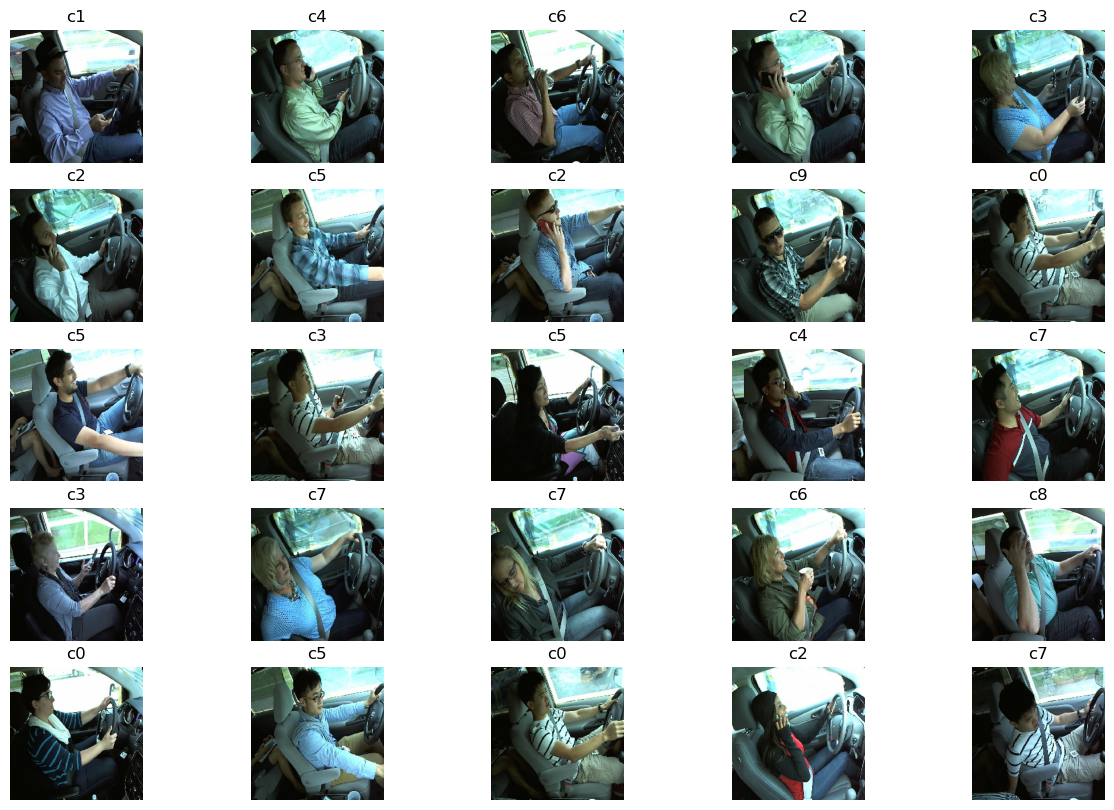

In [8]:
x,y = next(train_data)
a = train_data.class_indices
class_names = list(a.keys())  # storing class names in a list
 
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i].astype('uint8'))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

#### **Class Labels**

c0: safe driving

c1: texting - right

c2: talking on the phone - right

c3: texting - left

c4: talking on the phone - left

c5: operating the radio

c6: drinking

c7: reaching behind

c8: hair and makeup

c9: talking to passenger

In [9]:
def build_model(num_class):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=num_class, activation=tf.keras.activations.softmax)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy','Recall'],
    )
    return model

In [10]:
model = build_model(10)
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [12]:
batch_size=32
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size
 
# fit model
history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early]
)

Epoch 1/10
560/560 [==============================] - 341s 564ms/step - loss: 1.8535 - accuracy: 0.4069 - recall: 0.2112 - val_loss: 0.8440 - val_accuracy: 0.7958 - val_recall: 0.5451
Epoch 2/10
560/560 [==============================] - 298s 531ms/step - loss: 0.6866 - accuracy: 0.8185 - recall: 0.6581 - val_loss: 0.3571 - val_accuracy: 0.9420 - val_recall: 0.8676
Epoch 3/10
560/560 [==============================] - 297s 529ms/step - loss: 0.3491 - accuracy: 0.9251 - recall: 0.8594 - val_loss: 0.1995 - val_accuracy: 0.9688 - val_recall: 0.9402
Epoch 4/10
560/560 [==============================] - 296s 529ms/step - loss: 0.2110 - accuracy: 0.9602 - recall: 0.9282 - val_loss: 0.1314 - val_accuracy: 0.9777 - val_recall: 0.9645
Epoch 5/10
560/560 [==============================] - 296s 528ms/step - loss: 0.1459 - accuracy: 0.9745 - recall: 0.9570 - val_loss: 0.0935 - val_accuracy: 0.9846 - val_recall: 0.9728
Epoch 6/10
560/560 [==============================] - 310s 553ms/step - loss: 0.

In [13]:
model.save('Vgg19.h5')

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9967617392539978\nValidation Accuracy: 0.9937499761581421')

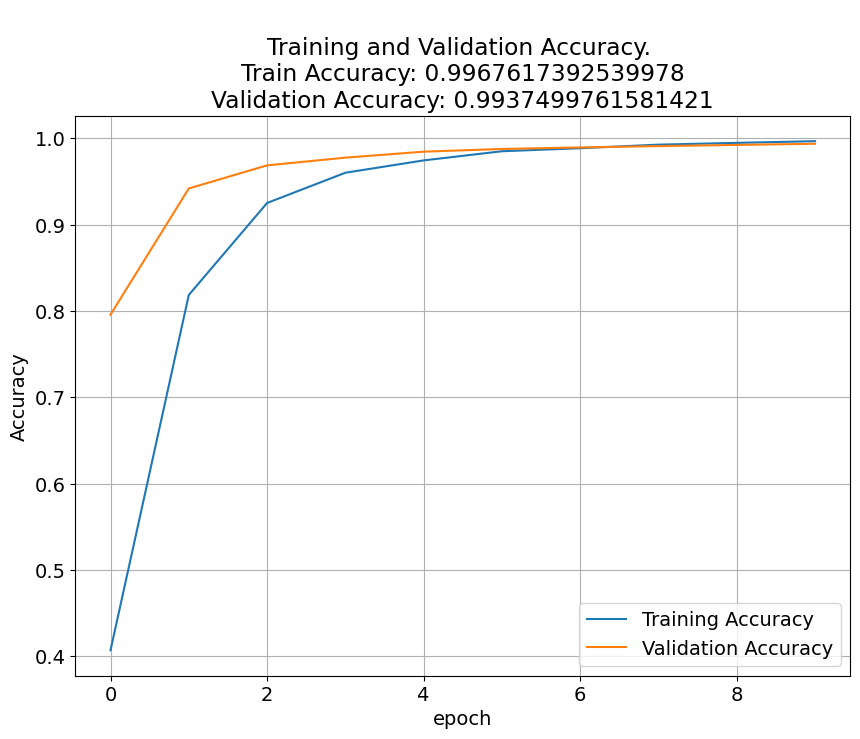

In [14]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


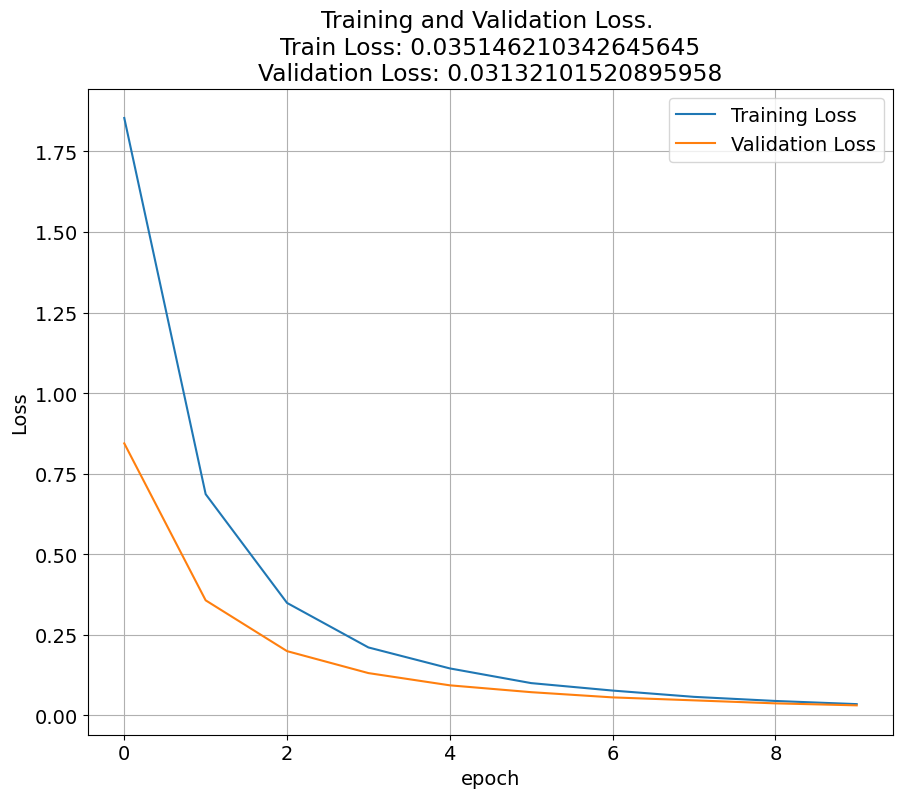

In [15]:
# loss
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# unfreezing the penultimate layer of the model
set_trainable = False
for layer in model.layers:
    if layer.name == 'dropout (Dropout)':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)

In [19]:
fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
561/561 [==============================] - 299s 532ms/step - loss: 0.0275 - accuracy: 0.9972 - recall: 0.9950 - val_loss: 0.0263 - val_accuracy: 0.9942 - val_recall: 0.9926
Epoch 11/15
561/561 [==============================] - 297s 529ms/step - loss: 0.0218 - accuracy: 0.9980 - recall: 0.9969 - val_loss: 0.0228 - val_accuracy: 0.9958 - val_recall: 0.9942
Epoch 12/15
561/561 [==============================] - 297s 529ms/step - loss: 0.0183 - accuracy: 0.9983 - recall: 0.9973 - val_loss: 0.0204 - val_accuracy: 0.9955 - val_recall: 0.9946
Epoch 13/15
561/561 [==============================] - 297s 529ms/step - loss: 0.0136 - accuracy: 0.9994 - recall: 0.9988 - val_loss: 0.0177 - val_accuracy: 0.9969 - val_recall: 0.9946
Epoch 14/15
561/561 [==============================] - 296s 528ms/step - loss: 0.0112 - accuracy: 0.9996 - recall: 0.9994 - val_loss: 0.0155 - val_accuracy: 0.9971 - val_recall: 0.9958
Epoch 15/15
561/561 [==============================] - 297s 530ms/step - lo

In [20]:
model.save('Vgg19_fine_tuning.h5')

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

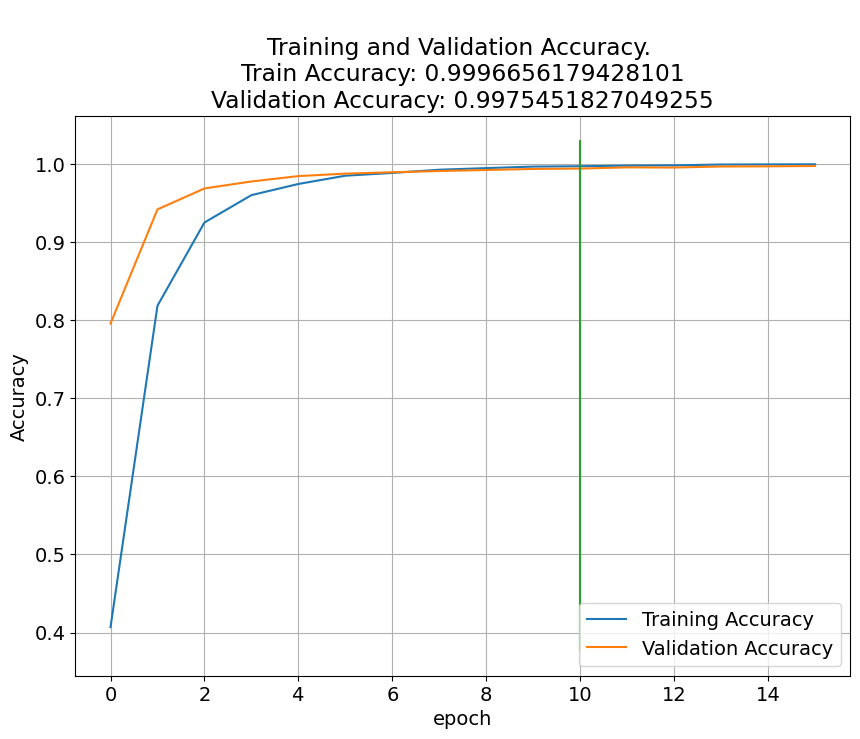

In [22]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.plot([10, 10],
          plt.ylim(), label='Start Fine Tuning')

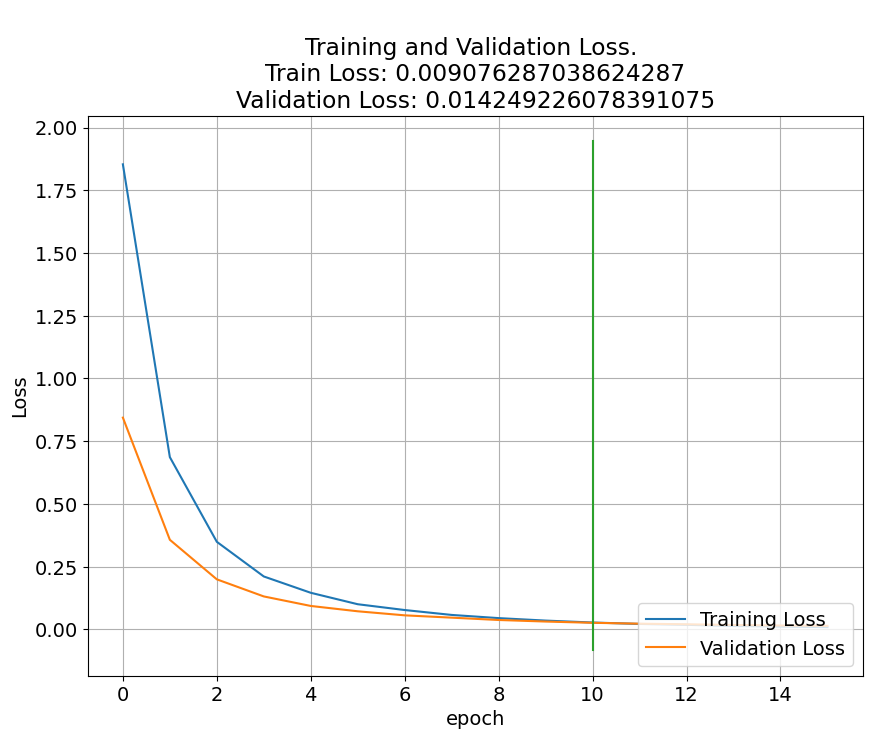

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title(f'\nTraining and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.plot([10, 10],
          plt.ylim(), label='Start Fine Tuning')

In [24]:
test_data = test_gen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = IMG_SIZE,
    classes = ['test'],
    batch_size = 32
)

Found 79726 images belonging to 1 classes.


In [25]:
preds = model.predict(test_data)

2492/2492 [==============================] - 544s 218ms/step


In [26]:
import os

base_dir = '/kaggle/working/'
test_imgs = os.path.join(base_dir, "imgs/test")

test_ids = sorted(os.listdir(test_imgs))

pred_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(preds)):
    pred_df.loc[i, 'img'] = test_ids[i]
    pred_df.loc[i, 'c0':'c9'] = preds[i]
    
pred_df.to_csv('vgg19-predictions.csv', index=False)

**End Of Code**